# We construct NNs which approximate frequency-localized functions




In [2]:
# Standard libraries
import time
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

# SymPy for symbolic mathematics
import sympy
from sympy import symbols, exp, re, im, I, E

# Scikit-learn for machine learning utilities
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import cohen_kappa_score, f1_score

# SciPy for mathematical optimizations and special functions
from scipy.optimize import minimize
from scipy.special import pro_ang1
from scipy.ndimage import rotate

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Cropping1D, Concatenate, MaxPooling1D, Dropout, 
    Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, 
    GlobalAveragePooling1D, Lambda, Input, Add, UpSampling1D, Multiply
)
from tensorflow.keras.losses import (
    mean_squared_error, Hinge, binary_crossentropy, categorical_crossentropy
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, 
    LearningRateScheduler, Callback
)


2025-01-30 14:19:10.004902: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 14:19:10.491884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:19:12.385607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:19:12.391287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 14:19:18.040299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Define the architecture based on K
def Archit(K):
    """
    Generates an array representing a neural network architecture.

    Parameters:
    K : list or tuple
        K[0] - Number of layers (L)
        K[1] - Scaling factor for neurons per layer

    Returns:
    Lay_x_Neu : ndarray
        An array where each row represents (layer index, neurons in the layer).
    """

    # Create an array with values from 1 to K[0] (number of layers)
    Array = np.arange(1, K[0] + 1)

    # Create a 2D array with the structure (layer index, neurons in the layer)
    Lay_x_Neu = np.column_stack((Array, K[1] * Array))

    return Lay_x_Neu

In [4]:
# Define the number of training samples using logarithmic spacing
Nsamples = np.logspace(2, np.log10(10000), num=10)

# Define the number of test samples as 20% of the training samples
Ntest = 0.2 * Nsamples


In [6]:
# This is the function we aim to approximate
def funct(x):
    """
    Computes the value of the function: g(x) = cos(10x) * exp(-πx^2)
    
    Parameters:
    x : array-like
        Input values (can be a scalar or array of x-values).
    
    Returns:
    g : array-like
        The function values at the given x.
    """
    # t is the variable (x in this case)
    g = np.cos(10 * x) * np.exp(-np.pi * x**2)
    
    return g



In [7]:
# This function generates 't' random values uniformly distributed between -1 and 1,
def samps(t):
       
    Values = np.random.uniform(-1, 1, t)
    

    
    return Values

In [8]:
def create_simple_NN(X_samp, labels, L, activation='relu'):
    
    """
    Creates a simple feedforward neural network.

    Parameters:
    X_samp (array-like): Sample input data (not used in model definition).
    labels (array-like): Corresponding labels (not used in model definition).
    L (tuple or list): A tuple/list where L[0] is the number of hidden layers, 
                       and L[1] is the number of neurons per layer.
    activation (str): Activation function for the hidden layers (default: 'relu').

    Returns:
    model (tf.keras.Model): A compiled Keras model with the specified architecture.
    """
   
    # Define the input layer with a single neuron
    model_input = Input(1)

     # Create L[0] hidden layers with L[1] neurons each    x = model_input
    for i in range(L[0]):
        x = Dense(L[1], activation=activation, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1))(x)

    # Define the output layer with a single neuron
    out = Dense(1)(x)

    # Create the model
    model = Model(inputs=model_input, outputs=out)

    return model


In [9]:
# Parameters for training
initial_learning_rate = 0.001  # Initial learning rate
decay_steps = 1000             # Number of steps before applying the decay
decay_rate = 0.85              # Decay rate (rate at which learning rate is reduced)
staircase = True               # Whether the decay is discrete (staircase)

final_epochs = 1000        # Maximum number of epochs
total_runs = 20        # these are the parameters that make things take long

VAL_SPLIT=0
BATCH_SIZE = 50

In [10]:
# Record the start time for estimating training duration

start_time = time.time()

# Initialize arrays to store results

results = np.zeros([len(Lay_x_Neu), len(Nsamples), total_runs])  # Stores test errors for each run
history = np.zeros([len(Lay_x_Neu), final_epochs, total_runs])   # Stores training history (MSE per epoch)

total_iterations = total_runs * len(Nsamples) * len(Lay_x_Neu)
counter = 0

# Run multiple training experiments

for run in range(total_runs):
    for i in range(len(Nsamples)):
        
        
        # Generate training samples and their corresponding function values


        training_sample = samps(int(Nsamples[i]))
        values = funct(training_sample)

        # Generate test samples and their corresponding function values

        test_sample = samps(int(Ntest[i]))
        test_values = funct(test_sample)

        for j in range(len(Lay_x_Neu)):

            # Define an exponentially decaying learning rate schedule
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=decay_steps,
                decay_rate=decay_rate,
                staircase=staircase
            )
            
            # Define the Adam optimizer using the learning rate schedule


            Optimizer = Adam(
                learning_rate=lr_schedule,  # Using the learning rate schedule
                beta_1=0.9,                 # Default value for beta_1
                beta_2=0.999,               # Default value for beta_2
                epsilon=1e-7                # Default value for epsilon
            )

            # Create and compile the neural network model

            model = create_simple_NN(training_sample, values, Lay_x_Neu[j])
            model.compile(loss="mean_squared_error", optimizer=Optimizer, metrics=["mean_squared_error"])
            
            
            hist = model.fit(training_sample, values, validation_split = VAL_SPLIT, epochs=final_epochs,  batch_size=BATCH_SIZE, shuffle=True, verbose = False)
            if i == len(Nsamples)-1:
                history[j, : , run] = hist.history['mean_squared_error']
            
            test_error = model.evaluate(test_sample, test_values, verbose=0)[0]
            test_error_rmse = np.sqrt(test_error)  # Calcula el RMSE



            results[j,i, run] += test_error_rmse
            counter += 1
            
            now_time = time.time()
            print('approx. ' + format((total_iterations-counter)*(now_time -  start_time)/counter, '.1f') + ' seconds remaining')
            
            
            print(format(100*counter / total_iterations, '.2f') + '% done')
            

approx. 6748.1 seconds remaining
0.05% done
approx. 5201.6 seconds remaining
0.10% done
approx. 4716.3 seconds remaining
0.15% done
approx. 4549.5 seconds remaining
0.20% done
approx. 4533.6 seconds remaining
0.25% done
approx. 4545.8 seconds remaining
0.30% done
approx. 4611.6 seconds remaining
0.35% done
approx. 4762.9 seconds remaining
0.40% done
approx. 4980.9 seconds remaining
0.45% done
approx. 5288.2 seconds remaining
0.50% done
approx. 5312.7 seconds remaining
0.55% done
approx. 5370.3 seconds remaining
0.60% done
approx. 5427.1 seconds remaining
0.65% done
approx. 5513.0 seconds remaining
0.70% done
approx. 5621.1 seconds remaining
0.75% done
approx. 5751.3 seconds remaining
0.80% done
approx. 5911.0 seconds remaining
0.85% done
approx. 6089.0 seconds remaining
0.90% done
approx. 6308.4 seconds remaining
0.95% done
approx. 6527.7 seconds remaining
1.00% done
approx. 6564.3 seconds remaining
1.05% done
approx. 6613.5 seconds remaining
1.10% done
approx. 6701.3 seconds remaining

approx. 44009.9 seconds remaining
7.70% done
approx. 43905.4 seconds remaining
7.75% done
approx. 43817.6 seconds remaining
7.80% done
approx. 43765.2 seconds remaining
7.85% done
approx. 43739.0 seconds remaining
7.90% done
approx. 43762.9 seconds remaining
7.95% done
approx. 43844.4 seconds remaining
8.00% done
approx. 43767.5 seconds remaining
8.05% done
approx. 43714.6 seconds remaining
8.10% done
approx. 43675.2 seconds remaining
8.15% done
approx. 43686.6 seconds remaining
8.20% done
approx. 43715.8 seconds remaining
8.25% done
approx. 43780.1 seconds remaining
8.30% done
approx. 43871.7 seconds remaining
8.35% done
approx. 43988.4 seconds remaining
8.40% done
approx. 44198.3 seconds remaining
8.45% done
approx. 44471.3 seconds remaining
8.50% done
approx. 44538.1 seconds remaining
8.55% done
approx. 44602.6 seconds remaining
8.60% done
approx. 44722.4 seconds remaining
8.65% done
approx. 44872.3 seconds remaining
8.70% done
approx. 45074.5 seconds remaining
8.75% done
approx. 45

approx. 48005.2 seconds remaining
16.70% done
approx. 47867.3 seconds remaining
16.75% done
approx. 47734.0 seconds remaining
16.80% done
approx. 47605.0 seconds remaining
16.85% done
approx. 47480.3 seconds remaining
16.90% done
approx. 47361.8 seconds remaining
16.95% done
approx. 47250.9 seconds remaining
17.00% done
approx. 47119.4 seconds remaining
17.05% done
approx. 46990.7 seconds remaining
17.10% done
approx. 46868.9 seconds remaining
17.15% done
approx. 46745.9 seconds remaining
17.20% done
approx. 46628.5 seconds remaining
17.25% done
approx. 46517.2 seconds remaining
17.30% done
approx. 46412.0 seconds remaining
17.35% done
approx. 46320.7 seconds remaining
17.40% done
approx. 46234.8 seconds remaining
17.45% done
approx. 46153.3 seconds remaining
17.50% done
approx. 46044.1 seconds remaining
17.55% done
approx. 45941.3 seconds remaining
17.60% done
approx. 45842.4 seconds remaining
17.65% done
approx. 45753.0 seconds remaining
17.70% done
approx. 45665.4 seconds remaining


approx. 44737.2 seconds remaining
25.65% done
approx. 44628.5 seconds remaining
25.70% done
approx. 44520.8 seconds remaining
25.75% done
approx. 44415.8 seconds remaining
25.80% done
approx. 44311.1 seconds remaining
25.85% done
approx. 44207.1 seconds remaining
25.90% done
approx. 44104.9 seconds remaining
25.95% done
approx. 44003.7 seconds remaining
26.00% done
approx. 43897.8 seconds remaining
26.05% done
approx. 43792.9 seconds remaining
26.10% done
approx. 43688.9 seconds remaining
26.15% done
approx. 43586.4 seconds remaining
26.20% done
approx. 43486.0 seconds remaining
26.25% done
approx. 43386.9 seconds remaining
26.30% done
approx. 43288.5 seconds remaining
26.35% done
approx. 43191.7 seconds remaining
26.40% done
approx. 43096.6 seconds remaining
26.45% done
approx. 43003.7 seconds remaining
26.50% done
approx. 42904.9 seconds remaining
26.55% done
approx. 42807.4 seconds remaining
26.60% done
approx. 42711.3 seconds remaining
26.65% done
approx. 42616.4 seconds remaining


approx. 37321.3 seconds remaining
34.60% done
approx. 37366.3 seconds remaining
34.65% done
approx. 37428.2 seconds remaining
34.70% done
approx. 37500.2 seconds remaining
34.75% done
approx. 37589.3 seconds remaining
34.80% done
approx. 37700.2 seconds remaining
34.85% done
approx. 37838.4 seconds remaining
34.90% done
approx. 38014.0 seconds remaining
34.95% done
approx. 38239.4 seconds remaining
35.00% done
approx. 38158.6 seconds remaining
35.05% done
approx. 38079.0 seconds remaining
35.10% done
approx. 37999.2 seconds remaining
35.15% done
approx. 37919.9 seconds remaining
35.20% done
approx. 37840.9 seconds remaining
35.25% done
approx. 37762.5 seconds remaining
35.30% done
approx. 37684.6 seconds remaining
35.35% done
approx. 37606.9 seconds remaining
35.40% done
approx. 37530.0 seconds remaining
35.45% done
approx. 37453.6 seconds remaining
35.50% done
approx. 37376.4 seconds remaining
35.55% done
approx. 37299.9 seconds remaining
35.60% done
approx. 37223.7 seconds remaining


approx. 30930.3 seconds remaining
43.55% done
approx. 30898.1 seconds remaining
43.60% done
approx. 30869.0 seconds remaining
43.65% done
approx. 30843.7 seconds remaining
43.70% done
approx. 30822.5 seconds remaining
43.75% done
approx. 30804.6 seconds remaining
43.80% done
approx. 30795.4 seconds remaining
43.85% done
approx. 30791.9 seconds remaining
43.90% done
approx. 30800.6 seconds remaining
43.95% done
approx. 30817.9 seconds remaining
44.00% done
approx. 30799.3 seconds remaining
44.05% done
approx. 30785.7 seconds remaining
44.10% done
approx. 30777.3 seconds remaining
44.15% done
approx. 30774.5 seconds remaining
44.20% done
approx. 30777.4 seconds remaining
44.25% done
approx. 30787.5 seconds remaining
44.30% done
approx. 30810.7 seconds remaining
44.35% done
approx. 30840.0 seconds remaining
44.40% done
approx. 30892.0 seconds remaining
44.45% done
approx. 30963.9 seconds remaining
44.50% done
approx. 30969.4 seconds remaining
44.55% done
approx. 30979.7 seconds remaining


approx. 25926.9 seconds remaining
52.50% done
approx. 25882.8 seconds remaining
52.55% done
approx. 25839.5 seconds remaining
52.60% done
approx. 25797.4 seconds remaining
52.65% done
approx. 25756.4 seconds remaining
52.70% done
approx. 25716.3 seconds remaining
52.75% done
approx. 25677.2 seconds remaining
52.80% done
approx. 25639.4 seconds remaining
52.85% done
approx. 25603.1 seconds remaining
52.90% done
approx. 25570.9 seconds remaining
52.95% done
approx. 25541.7 seconds remaining
53.00% done
approx. 25502.9 seconds remaining
53.05% done
approx. 25465.5 seconds remaining
53.10% done
approx. 25429.6 seconds remaining
53.15% done
approx. 25394.5 seconds remaining
53.20% done
approx. 25361.6 seconds remaining
53.25% done
approx. 25330.6 seconds remaining
53.30% done
approx. 25302.2 seconds remaining
53.35% done
approx. 25276.5 seconds remaining
53.40% done
approx. 25258.5 seconds remaining
53.45% done
approx. 25243.8 seconds remaining
53.50% done
approx. 25210.9 seconds remaining


approx. 21148.9 seconds remaining
61.45% done
approx. 21108.7 seconds remaining
61.50% done
approx. 21066.9 seconds remaining
61.55% done
approx. 21025.3 seconds remaining
61.60% done
approx. 20984.1 seconds remaining
61.65% done
approx. 20943.1 seconds remaining
61.70% done
approx. 20902.5 seconds remaining
61.75% done
approx. 20862.2 seconds remaining
61.80% done
approx. 20822.3 seconds remaining
61.85% done
approx. 20782.8 seconds remaining
61.90% done
approx. 20744.3 seconds remaining
61.95% done
approx. 20706.6 seconds remaining
62.00% done
approx. 20666.7 seconds remaining
62.05% done
approx. 20627.0 seconds remaining
62.10% done
approx. 20587.8 seconds remaining
62.15% done
approx. 20549.0 seconds remaining
62.20% done
approx. 20510.5 seconds remaining
62.25% done
approx. 20472.4 seconds remaining
62.30% done
approx. 20435.1 seconds remaining
62.35% done
approx. 20398.1 seconds remaining
62.40% done
approx. 20362.5 seconds remaining
62.45% done
approx. 20328.5 seconds remaining


approx. 16336.7 seconds remaining
70.40% done
approx. 16298.7 seconds remaining
70.45% done
approx. 16260.9 seconds remaining
70.50% done
approx. 16222.9 seconds remaining
70.55% done
approx. 16184.9 seconds remaining
70.60% done
approx. 16147.0 seconds remaining
70.65% done
approx. 16109.4 seconds remaining
70.70% done
approx. 16071.8 seconds remaining
70.75% done
approx. 16034.4 seconds remaining
70.80% done
approx. 15997.2 seconds remaining
70.85% done
approx. 15960.0 seconds remaining
70.90% done
approx. 15923.4 seconds remaining
70.95% done
approx. 15886.7 seconds remaining
71.00% done
approx. 15849.4 seconds remaining
71.05% done
approx. 15812.3 seconds remaining
71.10% done
approx. 15775.3 seconds remaining
71.15% done
approx. 15738.5 seconds remaining
71.20% done
approx. 15701.7 seconds remaining
71.25% done
approx. 15665.2 seconds remaining
71.30% done
approx. 15628.8 seconds remaining
71.35% done
approx. 15592.6 seconds remaining
71.40% done
approx. 15556.8 seconds remaining


approx. 11141.5 seconds remaining
79.35% done
approx. 11126.5 seconds remaining
79.40% done
approx. 11116.2 seconds remaining
79.45% done
approx. 11107.8 seconds remaining
79.50% done
approx. 11088.0 seconds remaining
79.55% done
approx. 11069.7 seconds remaining
79.60% done
approx. 11053.0 seconds remaining
79.65% done
approx. 11037.9 seconds remaining
79.70% done
approx. 11024.8 seconds remaining
79.75% done
approx. 11014.0 seconds remaining
79.80% done
approx. 11005.6 seconds remaining
79.85% done
approx. 11001.1 seconds remaining
79.90% done
approx. 11001.1 seconds remaining
79.95% done
approx. 11008.9 seconds remaining
80.00% done
approx. 10974.9 seconds remaining
80.05% done
approx. 10941.1 seconds remaining
80.10% done
approx. 10907.2 seconds remaining
80.15% done
approx. 10873.6 seconds remaining
80.20% done
approx. 10840.0 seconds remaining
80.25% done
approx. 10806.4 seconds remaining
80.30% done
approx. 10772.9 seconds remaining
80.35% done
approx. 10739.5 seconds remaining


approx. 6169.0 seconds remaining
88.45% done
approx. 6144.3 seconds remaining
88.50% done
approx. 6117.0 seconds remaining
88.55% done
approx. 6090.0 seconds remaining
88.60% done
approx. 6063.4 seconds remaining
88.65% done
approx. 6037.1 seconds remaining
88.70% done
approx. 6011.2 seconds remaining
88.75% done
approx. 5985.8 seconds remaining
88.80% done
approx. 5961.2 seconds remaining
88.85% done
approx. 5937.0 seconds remaining
88.90% done
approx. 5913.8 seconds remaining
88.95% done
approx. 5891.4 seconds remaining
89.00% done
approx. 5865.5 seconds remaining
89.05% done
approx. 5840.0 seconds remaining
89.10% done
approx. 5815.0 seconds remaining
89.15% done
approx. 5790.9 seconds remaining
89.20% done
approx. 5767.4 seconds remaining
89.25% done
approx. 5744.7 seconds remaining
89.30% done
approx. 5722.7 seconds remaining
89.35% done
approx. 5701.6 seconds remaining
89.40% done
approx. 5682.2 seconds remaining
89.45% done
approx. 5664.9 seconds remaining
89.50% done
approx. 56

approx. 1282.0 seconds remaining
97.60% done
approx. 1254.9 seconds remaining
97.65% done
approx. 1227.8 seconds remaining
97.70% done
approx. 1200.8 seconds remaining
97.75% done
approx. 1173.8 seconds remaining
97.80% done
approx. 1146.9 seconds remaining
97.85% done
approx. 1120.1 seconds remaining
97.90% done
approx. 1093.3 seconds remaining
97.95% done
approx. 1066.6 seconds remaining
98.00% done
approx. 1039.6 seconds remaining
98.05% done
approx. 1012.8 seconds remaining
98.10% done
approx. 985.9 seconds remaining
98.15% done
approx. 959.1 seconds remaining
98.20% done
approx. 932.4 seconds remaining
98.25% done
approx. 905.7 seconds remaining
98.30% done
approx. 879.0 seconds remaining
98.35% done
approx. 852.4 seconds remaining
98.40% done
approx. 825.9 seconds remaining
98.45% done
approx. 799.5 seconds remaining
98.50% done
approx. 772.8 seconds remaining
98.55% done
approx. 746.1 seconds remaining
98.60% done
approx. 719.4 seconds remaining
98.65% done
approx. 692.8 seconds

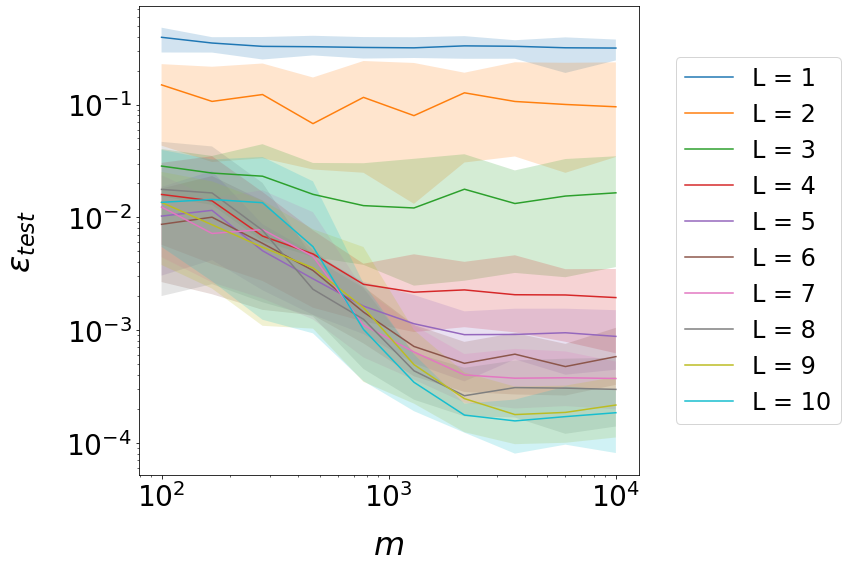

In [47]:
#Plot Error over training set sizes
plt.figure(figsize=(12, 8))  #Size
results_mean = np.mean(results, axis = 2)
results_lower = np.sort(results, axis = 2)[:,:,1] # 90% confidence intervals
results_upper = np.sort(results, axis = 2)[:,:,-2] # 90% confidence intervals

for i in range(len(Lay_x_Neu)):
    plt.loglog(Nsamples, results_mean[i,:], label=f'L = {i + 1}')
    plt.fill_between(Nsamples, results_lower[i,:], results_upper[i,:],  alpha=0.2)

plt.xlabel(r'$m$', fontsize=32, labelpad=18)
plt.ylabel(r'$\epsilon_{test}$', fontsize=32, labelpad=28)


# Increase font size of axis tick labels
plt.tick_params(axis='both', which='major', labelsize=28)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=28)  # Minor ticks

plt.legend(fontsize=28, loc='lower left')

plt.legend(
    fontsize=24,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place the legend to the right of the plot
    ncol=1  # Single column for legend entries
)

plt.tight_layout()  # Adjust the picture


plt.savefig("errorNN1D.pdf")


plt.show()